In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/b_d_classifier/'

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(150, 150), batch_size=32, class_mode='categorical')
print(generator.class_indices)

Found 826 images belonging to 2 classes.
{'bird': 0, 'drone': 1}


In [2]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'bird', 1: 'drone'}

In [3]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [4]:
import pandas as pd

bd_df = pd.DataFrame({'file_paths': generator.filepaths,'target_names': target_names, 'targets': generator.classes})
bd_df

,file_paths,target_names,targets
0,./datasets/b_d_classifier/bird/singleBirdinsky...,bird,0
1,./datasets/b_d_classifier/bird/singleBirdinsky...,bird,0
2,./datasets/b_d_classifier/bird/singleBirdinsky...,bird,0
3,./datasets/b_d_classifier/bird/singleBirdinsky...,bird,0
4,./datasets/b_d_classifier/bird/singleBirdinsky...,bird,0
...,...,...,...
821,./datasets/b_d_classifier/drone/yoto06497.png,drone,1
822,./datasets/b_d_classifier/drone/yoto10731.png,drone,1
823,./datasets/b_d_classifier/drone/yoto10760.png,drone,1
824,./datasets/b_d_classifier/drone/yoto10789.png,drone,1


In [5]:
# import os
# from glob import glob
# import pandas as pd

# train_root = './datasets/b_d_classifier/train'
# validation_root= './datasets/b_d_classifier/validation/'
# test_root = './datasets/b_d_classifier/test'

# def get_file_paths_and_targets(root_dir):
#     directories = glob(os.path.join(root_dir, '*'))
#     file_paths = []
#     targets = []
#     for directory in directories:
#         label = os.path.basename(directory)
#         files = glob(os.path.join(directory, '*'))
#         file_paths.extend(files)
#         targets.extend([label] * len(files))
#     return file_paths, targets

# # 각 폴더에서 파일 경로와 타겟 가져오기
# train_file_paths, train_targets = get_file_paths_and_targets(train_root)
# validation_file_paths, validation_targets = get_file_paths_and_targets(validation_root)
# test_file_paths, test_targets = get_file_paths_and_targets(test_root)

# # 모든 파일 경로와 타겟을 하나로 합치기
# all_file_paths = train_file_paths + validation_file_paths + test_file_paths
# all_targets = train_targets + validation_targets + test_targets

# # 데이터프레임으로 변환
# bd_df = pd.DataFrame({
#     'file_paths': all_file_paths,
#     'targets': all_targets
# })

# bd_df


In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(bd_df.file_paths, 
                 bd_df.targets, 
                 stratify=bd_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
1    342
0    318
Name: count, dtype: int64
targets
1    86
0    80
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, 
                 train_targets, 
                 stratify=train_targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
1    274
0    254
Name: count, dtype: int64
targets
1    68
0    64
Name: count, dtype: int64
targets
1    86
0    80
Name: count, dtype: int64


In [8]:
train_df = bd_df.iloc[train_images.index].reset_index(drop=True)
validation_df = bd_df.iloc[validation_images.index].reset_index(drop=True)
test_df = bd_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(528, 3)
(132, 3)
(166, 3)


In [9]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 64
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            # 에포크 종료 시, 객체 생성 및 데이터 섞기
            # 메모리 이슈가 있기 때문에 재정의 필요 (아래쪽 메소드 확인!)
            self.on_epoch_end()

    # __len__()는 전체 데이터 건수에서 batch_size 단위로 나눈 데이터 수
    # 예를 들어, 1000개의 데이터를 30 batch_size로 설정하면, 1 batch 당 33.33.. 개이다.
    # 이 때, 소수점은 무조건 올려서 33 + 1 = 34 개로 설정한다.
    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))


    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    # index : 몇번째 배치인지 나타내는 변수 (len에서 정의한 개수의 배치 수)
    # index: 0 
    # 0: batch)size
    # index * self.batch_size: (index+1) * self.batch_size
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        # 이미지의 경우 증강을 하거나 불러올 때 1개씩 처리되기 때문에 반복을 통해 이미지 변환을 시켜준다
        # for i in range(file_paths_batch.shape[0]):
        #     image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
        #     image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        for i in range(len(file_paths_batch)):
            image = cv2.imread(file_paths_batch[i])
            if image is None:
                print(f"Warning: Failed to read image {file_paths_batch[i]}")
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            # 분포를 맞추기 위해 해당 부분 추가
            if self.preprocess is not None:
                image = self.preprocess(image)

            results_batch[i] = image

        return results_batch, targets_batch


    # 메모리 이슈가 있기 때문에 직접 재정의
    # (file, target) 이 한쌍이 묶여서 섞여야함
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)
        

In [11]:
import albumentations as A
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

train_file_paths = train_df['file_paths'].values
# train_targets = train_df['targets'].values # SparseCategoricalCrossEntropy
train_targets = pd.get_dummies(train_df['targets']).values # CategoricalCrossEntropy

validation_file_paths = validation_df['file_paths'].values
# validation_targets = validation_df['targets'].values # SparseCategoricalCrossEntropy
validation_targets = pd.get_dummies(validation_df['targets']).values # CategoricalCrossEntropy

test_file_paths = test_df['file_paths'].values
# test_targets = test_df['targets'].values # SparseCategoricalCrossEntropy
test_targets = pd.get_dummies(test_df['targets']).values # CategoricalCrossEntropy

aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.OneOf([
            A.ColorJitter(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5) 
        ], p=1)        
    ], p=0.5)    


train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=xception_preprocess_input, 
                        shuffle=True)

validation_dataset = Dataset(validation_file_paths, 
                        validation_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=xception_preprocess_input)

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=xception_preprocess_input)

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2


def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobileneet': # 제한적인 장치에서 효과적인 모델
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(2, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, BinaryCrossentropy

model = create_model(model_name='xception', verbose=True)
# model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 31, 31,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 31, 31,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 31, 31,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 29, 29,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 29, 29,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 29, 29,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 29, 29,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 29, 29,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 29, 29,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 29, 29,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 29, 29,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 15, 15,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 15, 15,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 15, 15,    │          0 │ add_12[0][0]    

 Total params: 20,964,032 (79.97 MB)

 Trainable params: 20,909,504 (79.76 MB)

 Non-trainable params: 54,528 (213.00 KB)

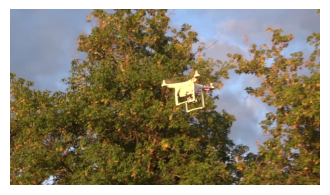

In [27]:
import cv2
import matplotlib.pyplot as plt


image = cv2.cvtColor(cv2.imread(train_df.file_paths[0]), cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')

show_image(image)

In [28]:
import gc

gc.collect()

6376

In [57]:
N_EPOCHS = 10

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[mcp_cb, rlr_cb, ely_cb]
                   )

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.9227 - loss: 0.3931 - val_acc: 0.6894 - val_loss: 3.6557 - learning_rate: 1.0000e-04
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.9107 - loss: 0.3887 - val_acc: 0.7197 - val_loss: 2.6213 - learning_rate: 1.0000e-04
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.9237 - loss: 0.3817 - val_acc: 0.7348 - val_loss: 2.0085 - learning_rate: 1.0000e-04
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.9113 - loss: 0.4118 - val_acc: 0.7500 - val_loss: 1.7650 - learning_rate: 1.0000e-04
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.9251 - loss: 0.3995 - val_acc: 0.7727 - val_loss: 1.3372 - learning_rate: 1.0000e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - acc: 0.9019 - loss: 0.3997 - val_acc: 0.7803 - val_loss: 1.2049 - learning_rate: 1.0000e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.9408 - loss: 0.3626 - val_acc: 0.7955 - val_loss: 1.1022 - learning_rate: 1.0000e-04
Epoch 

In [59]:
model.evaluate(test_dataset, batch_size=64)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - acc: 0.8464 - loss: 0.7567


[0.815737783908844, 0.8373494148254395]

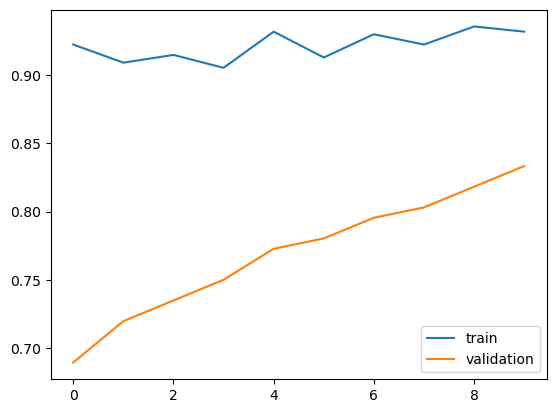

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # 정규화
    return image

def show_image(image_path, title=""):
    image = load_img(image_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

# 모델 로드 (이미 훈련된 모델을 로드하거나, 앞서 정의된 모델 사용)
# model = load_model('path_to_saved_model')  # 저장된 모델이 있다면 로드

# 또는 이미 정의된 모델을 사용
# model = create_model(model_name='mobilenet', verbose=True)
# model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

# 예측할 이미지 경로
test_image_path = './datasets/b_d_classifier/bird/singleBirdinsky115.jpeg'  # 실제 테스트 이미지 경로로 변경

# 이미지 로드 및 전처리
test_image = load_and_preprocess_image(test_image_path, target_size=(64, 64))

# 예측 수행
prediction = model.predict(test_image)

# 예측 결과 해석
predicted_value = prediction[0][0]
label = "Bird" if predicted_value >= 0.5 else "Drone"
# label = "Drone" if predicted_value >= 0.5 else "Bird"
confidence = predicted_value if predicted_value >= 0.5 else 1 - predicted_value

# 결과 표시
show_image(test_image_path, title=f"Prediction: {label} ({confidence * 100:.2f}%)")

NameError: name 'model' is not defined